<a href="https://colab.research.google.com/github/dtabuena/Workshop/blob/main/DFOF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tifffile
import numpy as np
# from google import colab
from matplotlib import pyplot as plt
import scipy
from tqdm import tqdm
import matplotlib as mpl
from scipy.signal import butter,filtfilt
import os


In [2]:
!jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
Paths used for configuration of notebook: 
    	/root/.jupyter/nbconfig/notebook.json
Paths used for configuration of notebook: 
    	
      - Validating: OK
Paths used for configuration of notebook: 
    	/root/.jupyter/nbconfig/notebook.json


In [3]:
def df_trace(trace,ref_inds):
    f0 = np.mean(trace[ref_inds])
    return (trace-f0)/f0

def exp_func(xdata,a,b,c):
    return a*np.exp(xdata/-b) + c

def z_trace(trace):
    std = np.nanstd(trace)
    mean = np.nanmean(trace)
    z_param =  {'std':std, 'mean':mean}
    return (trace-mean)/std, z_param

def bleach_cor(trace,ref_inds,lpf=0.2,order=1):
    b, a = butter(order, lpf, btype='lowpass')
    trace_f = filtfilt(b, a, trace)
    y_fittable = trace_f[ref_inds]
    p0= [np.max(trace), 20000, np.min(trace)]
    min_bound = [0,1000,0]
    max_bound = [np.max(trace)*2,np.inf,np.max(trace)*2]
    p = scipy.optimize.curve_fit(exp_func, ref_inds, y_fittable,p0=p0,bounds=(min_bound,max_bound))
    bleach_trace = exp_func(np.arange(len(trace)), p[0][0], p[0][1], p[0][2])
    trace_corr = trace/bleach_trace * bleach_trace[0]
    return trace_corr, bleach_trace, p[0]

def bin_stack(im,bin_factor):
    height = im.shape[1] // bin_factor
    width = im.shape[2] // bin_factor
    im = im[:, :height * bin_factor, : width * bin_factor]
    im = im.reshape(im.shape[0], height, bin_factor, width, bin_factor)
    im = im.sum((2, 4), dtype='uint32')
    return im

def proccess_pxl(trace,ref_inds,df_ind,return_df=True,return_z=True):
    trace = trace.astype('float32')    
    trace_corr, _, bleach_param = bleach_cor(trace,ref_inds)    
    if return_df: trace_corr = df_trace(trace_corr,df_inds)
    if return_z:
        trace_test,_ = z_trace(trace_corr)
        trace_corr[trace_test<-10] = np.nan
        trace_corr,_ = z_trace(trace_corr)
    return trace_corr, bleach_param

def vec_image(im):
    og_shape = im.shape
    im_vec = np.reshape(im,[og_shape[0],og_shape[1]*og_shape[2]])
    return im_vec, og_shape

def unvec_image(im,og_shape):
    im = np.reshape(im,[og_shape[0],og_shape[1],og_shape[2]])
    return im

In [4]:
# !wget -O file_name.tif 'https://www.dropbox.com/s/lhom1rp87qls64x/S1_10Hz_CNT%5B1-6072_EX0%5D.TIF?dl=0'

In [5]:
local_link = os.path.normpath('C:\\Users\\dennis.tabuena\\Dropbox (Gladstone)\\2023\\May 22\\S1_10Hz_CNT[1-6072_EX0].TIF')
im = tifffile.imread('/content/file_name', maxworkers=6)
im = bin_stack(im,2)

In [6]:


im_vec, og_shape = vec_image(im)
print(im_vec.shape,og_shape)

im_vec =im_vec.astype('float32')
ref_inds= np.concatenate([np.arange(100,1000),np.arange(4980,4999)])
df_inds = np.arange(900,1000)
param_list =[]
for pix in tqdm( range(im_vec.shape[1]) ):
    im_vec[:,pix],bleach_param = proccess_pxl(im_vec[:,pix],ref_inds,df_inds)
    param_list.append(bleach_param)
    

(6072, 90000) (6072, 300, 300)


100%|██████████| 90000/90000 [14:41<00:00, 102.09it/s]


In [7]:
im_unvec = unvec_image(im_vec,og_shape)
im_unvec_B = scipy.ndimage.gaussian_filter(im_unvec, .2)
im_vec_B, og_shape = vec_image(im_unvec_B)

In [8]:
og_shape

(6072, 300, 300)

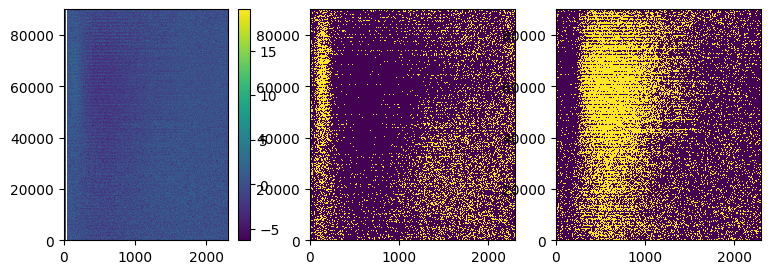

In [9]:
foi = np.arange(1200,3500)


up_spread_thresh = 0.75
down_spread_thresh = -0.75

fig,ax =plt.subplots(1,3,figsize=(9,3))
cb = ax[0].pcolorfast( im_vec_B[foi,:].T )
ax[1].pcolorfast( im_vec_B[foi,:].T>up_spread_thresh )
ax[2].pcolorfast( im_vec_B[foi,:].T<down_spread_thresh )
fig.colorbar(cb, ax=ax[0])

In [ ]:
p=1300

up_spread_thresh = 2
high_bool = im_vec_B[foi,:]>up_spread_thresh
trigs_up = np.diff(high_bool,axis=1,prepend=0)
x_g,y_g =np.meshgrid(np.arange(high_bool.shape[1]),np.arange(high_bool.shape[0]))
ind = np.multiply(trigs_up>0 , y_g).astype('float')
ind[ind==0]=np.nan
ind[ind>1000]=np.nan
up_image = np.nanmin(ind,axis=0)
print(up_image[p])
fig,ax =plt.subplots(1,3,figsize=(9,3))
ax[0].pcolorfast(high_bool.T)
ax[1].pcolorfast( ind.T)
ax[2].pcolorfast(trigs_up )
fig.colorbar(cb, ax=ax[0])




In [ ]:
up_image = np.nanmin(ind,axis=0)
up_image = unvec_image(up_image,[1, og_shape[1],og_shape[2]])
plt.contourf(up_image[0,:,:], levels=np.arange(0,200,20))

In [ ]:
im_unvec = unvec_image(im_vec_B,og_shape)
tifffile.imwrite('BC_file.TIF', im_unvec)